In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=eb8faca7adfc45ccdcb6f3f84840e80d6245ddef8a0672e26372aa00437de510
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


Tiempo de carga de datos: 0:00:02.787130


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


Tiempo de ejecución paralela (GPU): 0:00:00.504460
Tiempo total de ejecución: 0:00:10.659729
Procesamiento completado. Resultado guardado en diagonales_45_pycuda.dat.


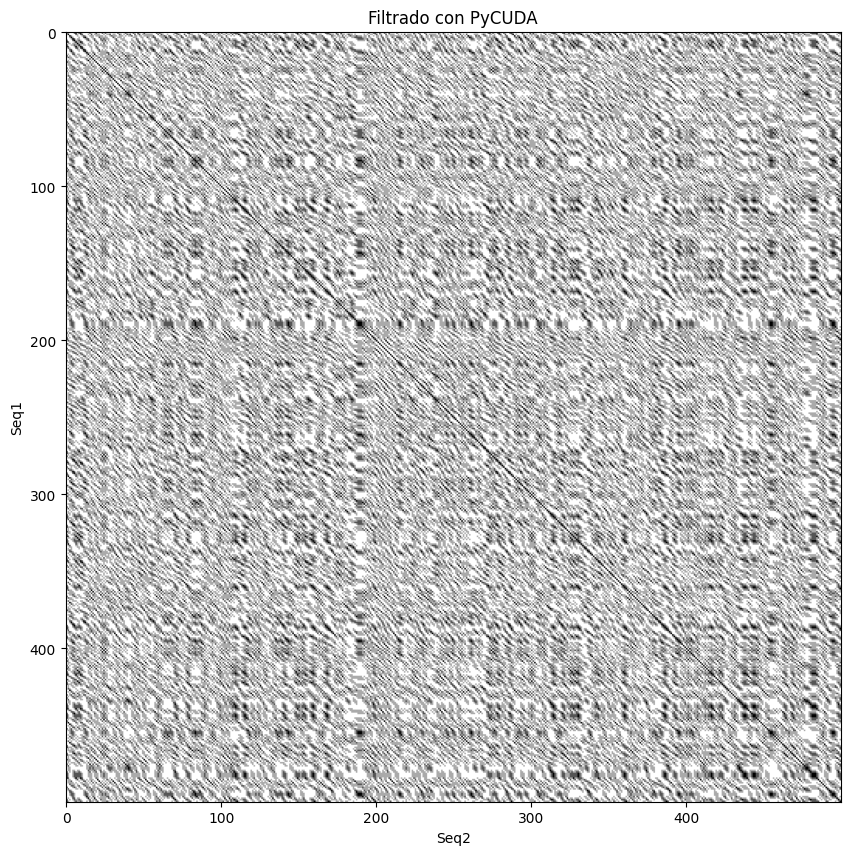

In [7]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
from datetime import datetime

def plot_dotplot(result_filename, seq1_len, seq2_len):
    """
    Plot the dot plot from the memory-mapped result.

    Args:
    - result_filename: Filename of memory-mapped result
    - seq1_len: Length of first sequence
    - seq2_len: Length of second sequence
    """
    result_map = np.memmap(result_filename, dtype='uint8', mode='r', shape=(seq1_len, seq2_len))
    plt.figure(figsize=(10, 10))
    plt.title("Filtrado con PyCUDA")
    plt.xlabel("Seq2")
    plt.ylabel("Seq1")
    plt.imshow(result_map[:500, :500], cmap='binary_r', aspect='auto')
    plt.savefig("pycuda.png")

# Kernel CUDA actualizado
cuda_kernel = """
#include <stdint.h>

__global__ void filter_45(uint8_t *input, uint8_t *output, int rows, int cols) {
    int x = blockIdx.x * blockDim.x + threadIdx.x; // Índice en X
    int y = blockIdx.y * blockDim.y + threadIdx.y; // Índice en Y

    if (x >= cols || y >= rows) return; // Verifica si está fuera de los límites

    int idx = y * cols + x; // Índice lineal
    output[idx] = input[idx]; // Copiar el pixel original

    // Verificar vecinos en la diagonal (45°)
    if (y > 0 && x > 0 && y < rows - 1 && x < cols - 1) {
        output[idx] = (input[(y - 1) * cols + (x - 1)] +
                       input[y * cols + x] +
                       input[(y + 1) * cols + (x + 1)]) / 3;
    }
}
"""

# Medición del tiempo total de ejecución
inicio_total = datetime.now()

# Tiempo de carga de datos
inicio_carga = datetime.now()

# Configuración para cargar el archivo .dat
input_filename = 'dotplot_result_thread.dat'

# Leer secuencias y preparar la matriz de entrada
with open('elemento1.fasta', 'r') as file:
    seq1 = file.read().splitlines()[1:]

with open('elemento2.fasta', 'r') as file:
    seq2 = file.read().splitlines()[1:]

seq1 = np.array(list("".join(seq1))).astype('str')
seq2 = np.array(list("".join(seq2))).astype('str')

mapping = {'A': 0, 'C': 1, 'G': 2, 'N': 3, 'T': 4}
seq1 = np.vectorize(mapping.get)(seq1).astype('uint8')
seq2 = np.vectorize(mapping.get)(seq2).astype('uint8')

seq1_len = len(seq1)
seq2_len = len(seq2)

# Cargar el archivo .dat como una imagen en escala de grises
input_map = np.memmap(input_filename, dtype='bool', mode='r', shape=(seq1_len, seq2_len))
imagen = 255 - (input_map.astype(np.uint8) * 255)  # Convertir de booleano a escala de grises (0 y 255)

fin_carga = datetime.now()
tiempo_carga = fin_carga - inicio_carga
print("Tiempo de carga de datos:", tiempo_carga)

# Dimensiones de la imagen
rows, cols = imagen.shape

# Inicializar buffers en la GPU
input_gpu = cuda.mem_alloc(imagen.nbytes)
output_gpu = cuda.mem_alloc(imagen.nbytes)

# Transferir datos de entrada a la GPU
cuda.memcpy_htod(input_gpu, imagen)

# Compilar el kernel CUDA
mod = SourceModule(cuda_kernel)
filter_45 = mod.get_function("filter_45")

# Configuración de bloques e hilos
block_size = (16, 16, 1)
grid_size = (int(np.ceil(cols / block_size[0])), int(np.ceil(rows / block_size[1])), 1)

# Medir tiempo de ejecución paralela (GPU)
inicio_paralela = datetime.now()

# Aplicar el filtro
filter_45(input_gpu, output_gpu, np.int32(rows), np.int32(cols), block=block_size, grid=grid_size)

# Transferir resultados de la GPU al host
resultado = np.empty_like(imagen)
cuda.memcpy_dtoh(resultado, output_gpu)

fin_paralela = datetime.now()
tiempo_paralela = fin_paralela - inicio_paralela
print("Tiempo de ejecución paralela (GPU):", tiempo_paralela)

# Guardar la matriz resultante en un archivo .dat
output_filename = 'diagonales_45_pycuda.dat'
output_map = np.memmap(output_filename, dtype='uint8', mode='w+', shape=resultado.shape)
output_map[:] = resultado[:]
output_map.flush()

# Generar el dotplot
plot_dotplot(output_filename, seq1_len, seq2_len)

fin_total = datetime.now()
tiempo_total = fin_total - inicio_total
print("Tiempo total de ejecución:", tiempo_total)

print(f"Procesamiento completado. Resultado guardado en {output_filename}.")
